In [12]:
# Import some 'base' packages
import pandas as pd
import numpy as np
import time
import string
import regex as re
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

# Import the VADER sentiment analyzer.
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Import sklearn model properties
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, f1_score, confusion_matrix
from sklearn.svm import SVR, SVC
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# impor the nlp-nltk package
import nltk
from nltk.stem import PorterStemmer

# download necessary packages
nltk.download('wordnet')
nltk.download('omw-1.4')

# predefine lemmatizer, stemmer and tokenizer
lemmatizer = nltk.stem.WordNetLemmatizer()
stemmer = PorterStemmer()
tokenizer = nltk.word_tokenize

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bartb\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\bartb\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
# Obtain the balanced (in terms of star occurrences) datasets
reviews = pd.read_csv(r"C:\Users\bartb\df_sample.csv")

# Index is set as first column if imported from csv
reviews = reviews.iloc[:,1:]

In [3]:
# Import the vader lexicon
vader_lexicon = pd.read_csv(r"C:\Users\bartb\Downloads\vader_lexicon.txt", sep = '\t', header = None)
vader_lexicon.columns = ['token','sentiment_mean','sentiment_stdev','sentiment_human']

In [4]:
%%time
# set the sentimentanalyzer and return the compound, positive, neutral and negative scores of the review texts.
sen_anal = SentimentIntensityAnalyzer()
reviews['sentiment'] = [sen_anal.polarity_scores(i).pop('compound',None) for i in reviews['text']]
reviews['sent_pos'] = [sen_anal.polarity_scores(i).pop('pos',None) for i in reviews['text']]
reviews['sent_neutral'] = [sen_anal.polarity_scores(i).pop('neu',None) for i in reviews['text']]
reviews['sent_neg'] = [sen_anal.polarity_scores(i).pop('neg',None) for i in reviews['text']]

Wall time: 1min 2s


In [23]:
# Preview the data.
reviews.head()

,index,restaurant,price,review_date,total_score,stars,text,word_count,sentiment,sent_pos,sent_neutral,sent_neg
0,24697,The Victoria,$$,2017-09-22,4.30,1,Never known a pub go downhill so fast.\nI've b...,132,0.7796,0.104,0.838,0.058
1,32602,Thai Crystal,££ - £££,2018-04-27,3.74,1,I used to love this place and I was there at l...,146,-0.5568,0.061,0.844,0.095
2,45238,The Golden Pagoda AKA The Lotus Garden,££ - £££,2015-08-27,2.45,1,Worst service in China Town. Food good when it...,37,-0.2960,0.069,0.833,0.098
3,33632,No 197 Chiswick Fire Station,££ - £££,2018-01-02,3.42,1,I came here with my family and we ordered a mi...,78,-0.7811,0.022,0.862,0.115
4,15299,The Lamb Tavern,££ - £££,2022-06-10,3.64,1,Decided to call in as it was a nice day and th...,124,0.2515,0.055,0.906,0.039


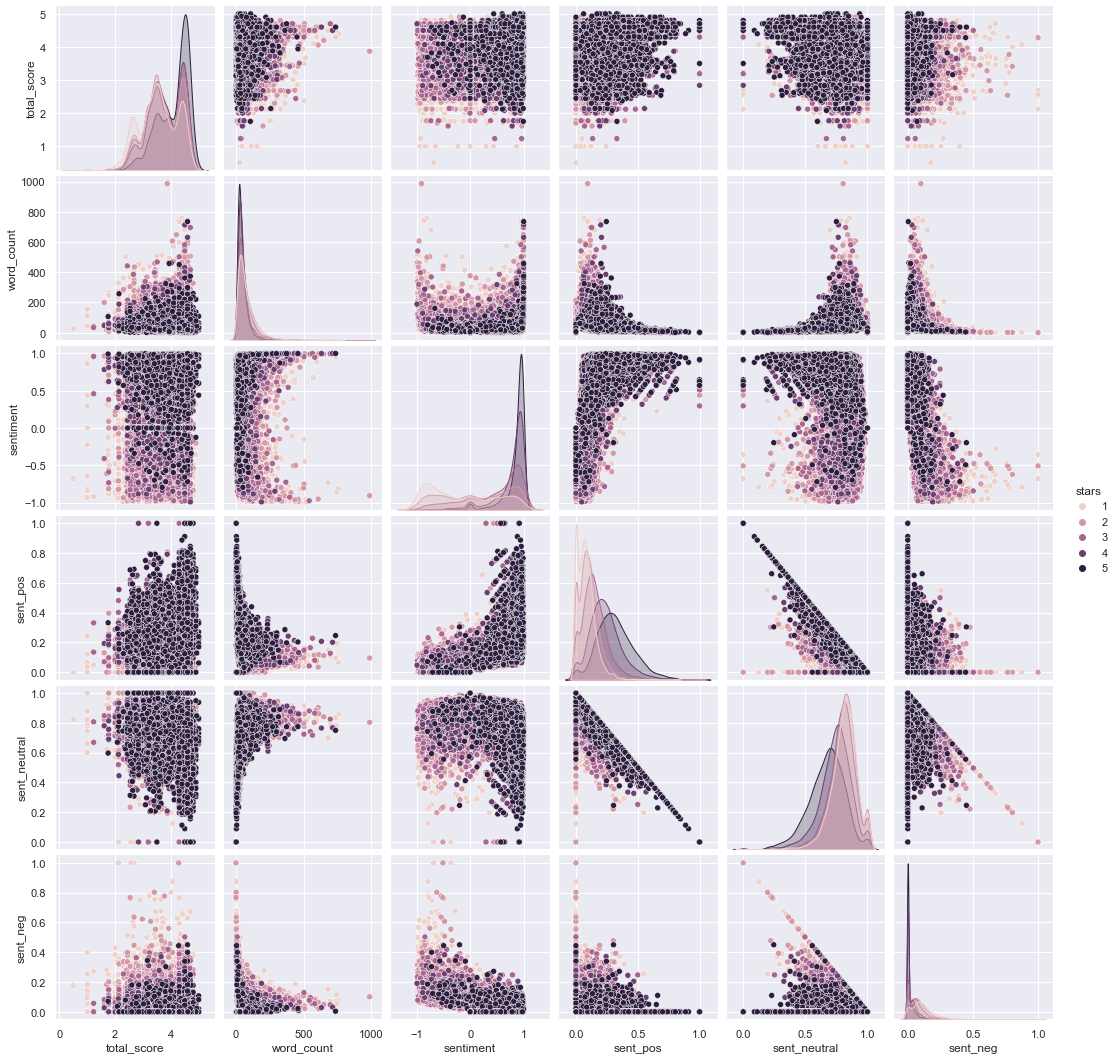

In [87]:
# A seaborn pairplot showing the different features; different sentiment methods, word count and total restaurant score
# None of the variables is showing any clear (enough) distinction between the stars given at reviews.
sns.pairplot(reviews.iloc[:,3:], hue = 'stars')

<AxesSubplot:xlabel='sent_neg', ylabel='stars'>

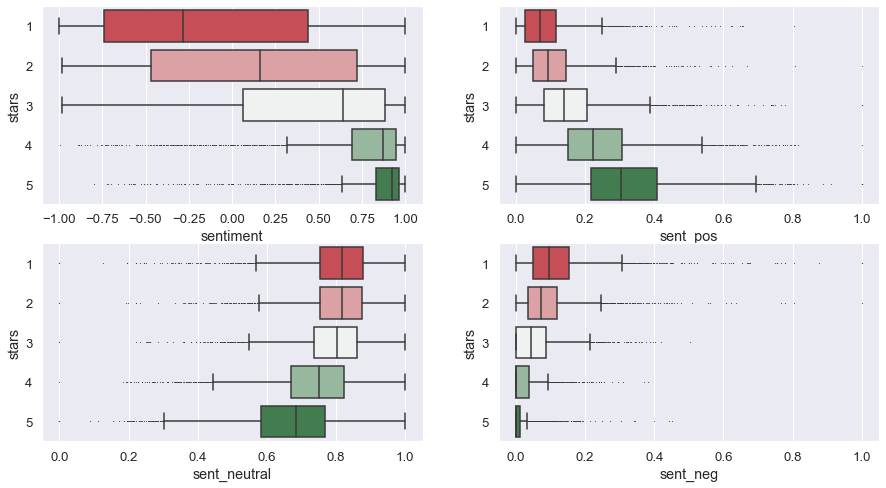

In [69]:
# Looking more close at the distribution rather than visually (as in the pairplot), 
# a vague difference can be seen in the star distributions with and sentiment category
# But the distributions show that giving an interval based on sentiment to predict stars is not duable.

palet = sns.diverging_palette(10,133,n=5)
sns.set(font_scale=1.2)
fig, ax = plt.subplots(2,2)
plt.gcf().set_size_inches(15, 8)
sns.boxplot(x='sentiment',y='stars', data=reviews, orient='h', palette=palet , ax=ax[0,0], fliersize=0.25)
sns.boxplot(x='sent_pos',y='stars', data=reviews, orient='h', palette=palet , ax=ax[0,1], fliersize=0.25)
sns.boxplot(x='sent_neutral',y='stars', data=reviews, orient='h', palette=palet , ax=ax[1,0], fliersize=0.25)
sns.boxplot(x='sent_neg',y='stars', data=reviews, orient='h', palette=palet , ax=ax[1,1], fliersize=0.25)

# The prediction of sentiment with text has a good accuracy.
# This leaves the question if stars express people's real judgement of their dining experience.
# In this script we therefore test if:
# (1) What is the best model and VADER sentiment score that can be best predicted by the review text? 
# (2) How to measure its accuracy?
# (3) What is the effect of certain words on the sentiment?
# (4) And in which does the impact differ from the sentiment scores in VADER?

In [5]:
# light pre-processing of text
def text_preprocess(x):
    x = x.lower() # lowercasing
    x = re.sub(r'http\S+', '',x) # removing hyperlinks
    x = x.replace('\n',' ') # remove next line indicator
    x = x.translate(str.maketrans('', '', string.punctuation)) # and remove punctuation
    return(x)

In [6]:
%%time
# Preprocessing, then stemming and lemmatizing of the text.
# Stemming and lemmatizing break down differently written words that mean the same in texts down to its base root
# This densifies the tf-idf matrix and increases the model accuracy.
reviews['adj_text'] = [text_preprocess(corpus) for corpus in reviews.text]
reviews['lemma_text'] = [' '.join([lemmatizer.lemmatize(word) for word in tokenizer(rev)]) for rev in reviews['adj_text']]
reviews['stem_text'] = [' '.join([stemmer.stem(word) for word in tokenizer(rev)]) for rev in reviews['adj_text']]

Wall time: 40 s


In [101]:
%%time
# word-based Polynomial (2nd degree) Regression with tf-idf vectorization (Positive sentiment, best)
# positive VADER sentiment can be best predicted by the input review-text
# this is thus used by us to determine the sentiment of review-text.
ls = list()
ls1 = list()
ls2 = list()
ls3 = list()
for i in range(0,10):
    X = list(reviews.stem_text.values) # stemmed texts as independent (X) values.
    y = list(reviews.sent_pos.values) # positive sentiment as dependent (Y) values.

    # Creating train text split, considering the sample-size, a test size of 0.1 is the best fit.
    x_train_str, x_test_str, y_train, y_test = train_test_split(X, y, test_size=0.1)

    # at min 25 corpora occurrences of a word, this is the best fit.
    tfidf = TfidfVectorizer(min_df = 25, max_df = 0.4) 

    # create the vocabulary
    tfidf.fit(x_train_str)
    x_train = tfidf.transform(x_train_str)
    x_test = tfidf.transform(x_test_str)
    
    # at min 25 corpora occurrences of a word, this is the best fit.
    tfidf2 = TfidfVectorizer(min_df = 25, max_df = 0.4)
    
    # create the vocabulary
    tfidf2.fit(x_train_str)
    x_s = tfidf.transform(X)
    
    # Create a scikit-learn pipeline adding polynomials to the linear regression.
    polyreg=make_pipeline(PolynomialFeatures(degree = 2),LinearRegression())
    polyreg.fit(x_train, y_train)
    y_pred = polyreg.predict(x_test) # predict validation
    
    # Return the R2, RSME
    ls.append(r2_score(y_test, y_pred))
    ls1.append(polyreg.predict(x_s))
    ls2.append(mean_squared_error(y_test, y_pred, squared=False))
    ls3.append(polyreg[1].intercept_)
    
    print('r2:',r2_score(y_test, y_pred))
    print('rsme:',mean_squared_error(y_test, y_pred, squared=False))

# The final accuracy is averaged over 10 iterations, preventing dependency on one train-test sample seed.
# A test size of 0.2 gives a 0.06 lower average R2, but lower spread among the iterations
print(' ')
print('stemmed mean r2 of 10', round(np.mean(ls),3))
print('stemmed mean rmse of 10 iterations', round(np.mean(ls2),4))
print('sentiment compound mean', round(np.mean(reviews.sent_pos),3))
print('proportional RSME', round((np.mean(ls2))/(np.mean(reviews.sent_pos)),4))
print('intercept', round(np.mean(ls3))) 

r2: 0.8360670922704828
rsme: 0.056763156892489224
r2: 0.8336952953051902
rsme: 0.06110069764118323
r2: 0.8441402509534122
rsme: 0.058458087677788644
r2: 0.8336489217253518
rsme: 0.0603577981907354
r2: 0.8057460486146828
rsme: 0.06295257653993554
r2: 0.8489245447865215
rsme: 0.05755702489854958
r2: 0.8523052902916377
rsme: 0.05521365529101384
r2: 0.829814030887867
rsme: 0.059274259989989045
r2: 0.8146714235793959
rsme: 0.061213174198215196
r2: 0.8341538695903312
rsme: 0.060436333898951144
 
stemmed mean r2 of 10 0.833
stemmed mean rmse of 10 iterations 0.0593
sentiment compound mean 0.179
proportional RSME 0.3319
intercept 0
Wall time: 15min 21s


In [108]:
%%time
# word-based Linear Regression with tf-idf vectorization Positive sentiment (best)
# Extracting and processing the polynomial coefficients quite time-consuming, thus a plain linear regression is used for now
ls = list()
ls1 = list()
ls2 = list()
ls3 = list()
df1 = pd.DataFrame()
for i in range(0,10):
    X = list(reviews.stem_text.values)
    y = list(reviews.sent_pos.values)# the labels we want to predict --> Y

    # Creating train text split, considering the sample-size, a test size of 0.1 is the best fit
    x_train_str, x_test_str, y_train, y_test = train_test_split(X, y, test_size=0.1)
    tfidf = TfidfVectorizer(min_df = 25, max_df = 0.4) # at min 25 corpora occurrences of a word
    
    # create the vocabulary
    tfidf.fit(x_train_str) 
    x_train = tfidf.transform(x_train_str)
    x_test = tfidf.transform(x_test_str)
    
    # at min 25 corpora occurrences of a word, this is the best fit.
    tfidf2 = TfidfVectorizer(min_df = 25, max_df = 0.4)
    
    # create the vocabulary
    tfidf2.fit(x_train_str)
    x_s = tfidf.transform(X)
    
    # Set and fit the model
    lr = LinearRegression()
    lr.fit(x_train, y_train)
    y_pred = lr.predict(x_test)
    
    # Return the R2, RSME
    ls.append(r2_score(y_test, y_pred))
    ls1.append(lr.predict(x_s))
    ls2.append(mean_squared_error(y_test, y_pred, squared=False))
    ls3.append(lr.intercept_)

    df = pd.DataFrame(lr.coef_)
    df.index = tfidf.get_feature_names()
    df1 = df1.join(df, how = 'outer', rsuffix = i)
    
print('stemmed mean r2 of 10 iterations', round(np.mean(ls),3))
print('stemmed mean rmse of 10 iterations', round(np.mean(ls2),4))
print('sentiment positive mean', round(np.mean(reviews.sent_pos),3))
print('proportional RSME', round(np.mean(ls2)/np.mean(reviews.sent_pos),4))
print('intercept', round(np.mean(ls3)))

stemmed mean r2 of 10 iterations 0.796
stemmed mean rmse of 10 iterations 0.0653
sentiment positive mean 0.179
proportional RSME 0.3651
intercept 0
Wall time: 43 s


In [91]:
%%time
# word-based Linear Regression with tf-idf vectorization Negative sentiment
ls = list()
ls1 = list()
ls2 = list()
ls3 = list()
df1 = pd.DataFrame()
for i in range(0,10):
    X = list(reviews.stem_text.values)
    y = list(reviews.sent_neg.values)# the labels we want to predict --> Y

    # Creating train text split, considering the sample-size, a test size of 0.1 is the best fit
    x_train_str, x_test_str, y_train, y_test = train_test_split(X, y, test_size=0.1)
    tfidf = TfidfVectorizer(min_df = 25, max_df = 0.4) # at min 25 corpora occurrences of a word
    
    # create the vocabulary
    tfidf.fit(x_train_str) 
    x_train = tfidf.transform(x_train_str)
    x_test = tfidf.transform(x_test_str)
    
    # at min 25 corpora occurrences of a word, this is the best fit.
    tfidf2 = TfidfVectorizer(min_df = 25, max_df = 0.4)
    
    # create the vocabulary
    tfidf2.fit(x_train_str)
    x_s = tfidf.transform(X)
    
    # Set and fit the model
    lr = LinearRegression()
    lr.fit(x_train, y_train)
    y_pred = lr.predict(x_test)
    
    # Return the R2, RSME
    ls.append(r2_score(y_test, y_pred))
    ls1.append(lr.predict(x_s))
    ls2.append(mean_squared_error(y_test, y_pred, squared=False))
    ls3.append(lr.intercept_)

    #df = pd.DataFrame(lr.coef_)
    #df.index = tfidf.get_feature_names()
    #df1 = df1.join(df, how = 'outer', rsuffix = i)
    
print('stemmed mean r2 of 10 iterations', round(np.mean(ls),3))
print('stemmed mean rmse of 10 iterations', round(np.mean(ls2),4))
print('sentiment negative mean', round(np.mean(reviews.sent_neg),3))
print('intercept', round(np.mean(ls3)))

stemmed mean r2 of 10 iterations 0.651
stemmed mean rmse of 10 iterations 0.046
sentiment negative mean 0.058
intercept 0
Wall time: 45.7 s


In [92]:
%%time
# word-based Linear Regression with tf-idf vectorization Compound sentiment
ls = list()
ls1 = list()
ls2 = list()
ls3 = list()
df1 = pd.DataFrame()
for i in range(0,10):
    X = list(reviews.stem_text.values)
    y = list(reviews.sentiment.values)# the labels we want to predict --> Y

    # Creating train text split, considering the sample-size, a test size of 0.1 is the best fit
    x_train_str, x_test_str, y_train, y_test = train_test_split(X, y, test_size=0.1)
    tfidf = TfidfVectorizer(min_df = 25, max_df = 0.4) # at min 25 corpora occurrences of a word
    
    # create the vocabulary
    tfidf.fit(x_train_str) 
    x_train = tfidf.transform(x_train_str)
    x_test = tfidf.transform(x_test_str)
    
    # at min 25 corpora occurrences of a word, this is the best fit.
    tfidf2 = TfidfVectorizer(min_df = 25, max_df = 0.4)
    
    # create the vocabulary
    tfidf2.fit(x_train_str)
    x_s = tfidf.transform(X)
    
    # Set and fit the model
    lr = LinearRegression()
    lr.fit(x_train, y_train)
    y_pred = lr.predict(x_test)
    
    # Return the R2, RSME
    ls.append(r2_score(y_test, y_pred))
    ls1.append(lr.predict(x_s))
    ls2.append(mean_squared_error(y_test, y_pred, squared=False))
    ls3.append(lr.intercept_)

    #df = pd.DataFrame(lr.coef_)
    #df.index = tfidf.get_feature_names()
    #df1 = df1.join(df, how = 'outer', rsuffix = i)
    
print('stemmed mean r2 of 10 iterations', round(np.mean(ls),3))
print('stemmed mean rmse of 10 iterations', round(np.mean(ls2),4))
print('sentiment compound mean', round(np.mean(reviews.sentiment),3))
print('proportional RSME', round((np.mean(ls2)+1)/(np.mean(reviews.sentiment)+1),4))
print('intercept', round(np.mean(ls3))) 
#+1 is to include negative sentiment in the RSME.

stemmed mean r2 of 10 iterations 0.607
stemmed mean rmse of 10 iterations 0.3873
sentiment compound mean 0.4
proportional RSME 0.9909
intercept 0
Wall time: 40.4 s


In [119]:
%%time
# word-based Linear SVM Regression with tf-idf vectorization Postive sentiment
ls = list()
ls1 = list()
ls2 = list()
ls3 = list()
print('R2-score by iteration')
for i in range(0,10):
    # word-based Logisic Regression with tf-idf vectorization
    X = list(reviews.stem_text.values)
    y = list(reviews.sent_pos.values)# the labels we want to predict --> Y

    # Creating train text split, considering the sample-size, a test size of 0.1 is the best fit
    x_train_str, x_test_str, y_train, y_test = train_test_split(X, y, test_size=0.1)
    tfidf = TfidfVectorizer(min_df = 25, max_df = 0.4) # at min 25 corpora occurrences of a word

    # create the vocabulary
    tfidf.fit(x_train_str) 
    x_train = tfidf.transform(x_train_str).toarray()
    x_test = tfidf.transform(x_test_str).toarray()
    y_train = np.array(y_train).reshape(-1, 1)
    y_test = np.array(y_test).reshape(-1, 1)
    
    # at min 25 corpora occurrences of a word, this is the best fit.
    tfidf2 = TfidfVectorizer(min_df = 25, max_df = 0.4)
    
    # create the vocabulary
    tfidf2.fit(x_train_str)
    x_s = tfidf.transform(X).toarray()

    # Set and fit the model
    svr = SVR(kernel = "linear", C = 1)
    svr.fit(x_train, y_train)
    y_pred = svr.predict(x_test)
    
    # Return the R2, RSME
    ls.append(r2_score(y_test, y_pred))
    ls1.append(svr.predict(x_s))
    ls2.append(mean_squared_error(y_test, y_pred, squared=False))
    ls3.append(svr.intercept_)
    
    print(i,r2_score(y_test, y_pred))
    
print('stemmed mean r2 of 10 iterations', round(np.mean(ls),3))
print('stemmed mean rmse of 10 iterations', round(np.mean(ls2),4))
print('sentiment positive mean', round(np.mean(reviews.sent_pos),3))
print('proportional RSME', round((np.mean(ls2))/(np.mean(reviews.sent_pos)),4))
print('intercept', round(np.mean(ls3))) 

R2-score by iteration
0 0.7669535729620327
1 0.7363301910708222
2 0.7472336920762251
3 0.7443889217402635
4 0.7416135405512301
5 0.7561600143386897
6 0.7645611695138615
7 0.7304608179848053
8 0.7550638435128225
9 0.7420861533655783
stemmed mean r2 of 10 iterations 0.748
stemmed mean rmse of 10 iterations 0.0722
sentiment positive mean 0.179
proportional RSME 0.4041
intercept 0
Wall time: 20min 42s
Parser   : 126 ms


In [120]:
%%time
# word-based Radial Basis Function (RBF) SVM Regression with tf-idf vectorization Postive sentiment
ls = list()
ls1 = list()
ls2 = list()
ls3 = list()
print('R2-score by iteration')
for i in range(0,10):
    # word-based Logisic Regression with tf-idf vectorization
    X = list(reviews.stem_text.values)
    y = list(reviews.sent_pos.values)# the labels we want to predict --> Y

    # Creating train text split, considering the sample-size, a test size of 0.1 is the best fit
    x_train_str, x_test_str, y_train, y_test = train_test_split(X, y, test_size=0.1)
    tfidf = TfidfVectorizer(min_df = 25, max_df = 0.4) # at min 25 corpora occurrences of a word

    # create the vocabulary
    tfidf.fit(x_train_str) 
    x_train = tfidf.transform(x_train_str).toarray()
    x_test = tfidf.transform(x_test_str).toarray()
    y_train = np.array(y_train).reshape(-1, 1)
    y_test = np.array(y_test).reshape(-1, 1)
    
    # at min 25 corpora occurrences of a word, this is the best fit.
    tfidf2 = TfidfVectorizer(min_df = 25, max_df = 0.4)
    
    # create the vocabulary
    tfidf2.fit(x_train_str)
    x_s = tfidf.transform(X).toarray()

    # Set and fit the model
    svr = SVR(kernel = "rbf", C = 1)
    svr.fit(x_train, y_train)
    y_pred = svr.predict(x_test)
    
    # Return the R2, RSME
    ls.append(r2_score(y_test, y_pred))
    ls1.append(svr.predict(x_s))
    ls2.append(mean_squared_error(y_test, y_pred, squared=False))
    ls3.append(svr.intercept_)
    
    print(i,r2_score(y_test, y_pred))
    
print('stemmed mean r2 of 10 iterations', round(np.mean(ls),3))
print('stemmed mean rmse of 10 iterations', round(np.mean(ls2),4))
print('sentiment positive mean', round(np.mean(reviews.sent_pos),3))
print('proportional RSME', round((np.mean(ls2))/(np.mean(reviews.sent_pos)),4))
print('intercept', round(np.mean(ls3))) 

R2-score by iteration
0 0.7587613997317728
1 0.7666799588747613
2 0.7518827247265851
3 0.7491802271964272
4 0.7539366533220121
5 0.7753297784073693
6 0.7635908297380687
7 0.7640778489962683
8 0.7689499734474731
9 0.7444954719614655
stemmed mean r2 of 10 iterations 0.76
stemmed mean rmse of 10 iterations 0.0706
sentiment positive mean 0.179
proportional RSME 0.3947
intercept 0
Wall time: 22min 40s


In [121]:
%%time
# word-based Polynomial (2nd degree) SVM Regression with tf-idf vectorization Postive sentiment
ls = list()
ls1 = list()
ls2 = list()
ls3 = list()
print('R2-score by iteration')
for i in range(0,10):
    # word-based Logisic Regression with tf-idf vectorization
    X = list(reviews.stem_text.values)
    y = list(reviews.sent_pos.values)# the labels we want to predict --> Y

    # Creating train text split, considering the sample-size, a test size of 0.1 is the best fit
    x_train_str, x_test_str, y_train, y_test = train_test_split(X, y, test_size=0.1)
    tfidf = TfidfVectorizer(min_df = 25, max_df = 0.4) # at min 25 corpora occurrences of a word

    # create the vocabulary
    tfidf.fit(x_train_str) 
    x_train = tfidf.transform(x_train_str).toarray()
    x_test = tfidf.transform(x_test_str).toarray()
    y_train = np.array(y_train).reshape(-1, 1)
    y_test = np.array(y_test).reshape(-1, 1)
    
    # at min 25 corpora occurrences of a word, this is the best fit.
    tfidf2 = TfidfVectorizer(min_df = 25, max_df = 0.4)
    
    # create the vocabulary
    tfidf2.fit(x_train_str)
    x_s = tfidf.transform(X).toarray()

    # Set and fit the model
    svr = SVR(kernel = "poly", degree = 2, C = 1)
    svr.fit(x_train, y_train)
    y_pred = svr.predict(x_test)
    
    # Return the R2, RSME
    ls.append(r2_score(y_test, y_pred))
    ls1.append(svr.predict(x_s))
    ls2.append(mean_squared_error(y_test, y_pred, squared=False))
    ls3.append(svr.intercept_)
    
    print(i,r2_score(y_test, y_pred))
    
print('stemmed mean r2 of 10 iterations', round(np.mean(ls),3))
print('stemmed mean rmse of 10 iterations', round(np.mean(ls2),4))
print('sentiment positive mean', round(np.mean(reviews.sent_pos),3))
print('proportional RSME', round((np.mean(ls2))/(np.mean(reviews.sent_pos)),4))
print('intercept', round(np.mean(ls3))) 

R2-score by iteration
0 0.7003413476391103
1 0.666362309372921
2 0.6687639550628806
3 0.6980697916399923
4 0.7063385454926279
5 0.7009733490515557
6 0.7027425980268596
7 0.6901625387695303
8 0.6952993381470769
9 0.6895009616735992
stemmed mean r2 of 10 iterations 0.692
stemmed mean rmse of 10 iterations 0.0809
sentiment positive mean 0.179
proportional RSME 0.4525
intercept 0
Wall time: 40min 9s
Compiler : 306 ms


In [74]:
%%time
# word-based Logistic Regression with tf-idf vectorization positive sentiment to stars
ls = list()
ls1 = list()
arr = np.array(np.zeros((5,5)))
for i in range(0,10):
    #bi-gram based logistic regression with tf-idf vectorization
    X = list(reviews.sent_pos.values)
    y = list(reviews.stars.values)# the labels we want to predict --> Y
    labels = ['1-star', '2-star', '3-star', '4-star', '5-star']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1) 
    X_train = np.array(X_train).reshape(-1,1)
    X_test = np.array(X_test).reshape(-1,1)
    y_train = np.array(y_train).reshape(-1,1)
    y_test = np.array(y_test).reshape(-1,1)
    
    lr = LogisticRegression(solver='lbfgs')
    lr.fit(np.array(X_train).reshape(-1, 1), np.array(y_train).reshape(-1,1))

    y_pred = lr.predict(X_test)

    ls.append(f1_score(y_test, y_pred.tolist(), average = 'micro'))
    ls1.append(confusion_matrix(y_test, y_pred))
    arr = arr + confusion_matrix(y_test, y_pred)
print('confusion matrix average')
print(np.round(arr/10))
print('f1_score average',round(np.mean(np.array(ls)),3))

confusion matrix average
[[266.  65.  56.  18.   8.]
 [211.  68.  88.  36.  16.]
 [124.  62. 106.  78.  46.]
 [ 47.  33.  86. 113. 143.]
 [ 19.  12.  48.  85. 240.]]
f1_score average 0.383
Wall time: 2.07 s


In [98]:
%%time
# word-based Logistic Regression with tf-idf vectorization positive sentiment to stars
ls = list()
ls1 = list()
arr = np.array(np.zeros((5,5)))
for i in range(0,10):
    #bi-gram based logistic regression with tf-idf vectorization
    X = list(reviews.stem_text.values)
    y = list(reviews.stars.values)# the labels we want to predict --> Y
    labels = ['1-star', '2-star', '3-star', '4-star', '5-star']

    X_train_str, X_test_str, y_train, y_test = train_test_split(X, y, test_size=0.1)

    tfidf2 = TfidfVectorizer(min_df = 25, max_df = 0.4) #n-gram range creates the bigrams, at least 25 occ

    tfidf2.fit(X_train_str) # create the vocabulary

    X_train = tfidf2.transform(X_train_str)
    X_test = tfidf2.transform(X_test_str)

    lr = LogisticRegression(solver='lbfgs')
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_test)

    ls.append(f1_score(y_test, y_pred.tolist(), average = 'micro'))
    ls1.append(confusion_matrix(y_test, y_pred))
    arr = arr + confusion_matrix(y_test, y_pred)
print('confusion matrix average')
print(np.round(arr/10))
print('f1_score average',round(np.mean(ls),3))

confusion matrix average
[[285.  96.  26.   9.   6.]
 [114. 165.  88.  25.  11.]
 [ 42.  94. 178.  82.  19.]
 [ 16.  20.  71. 214.  98.]
 [ 10.   8.  18. 100. 281.]]
f1_score average 0.542
Wall time: 40.4 s


In [95]:
# Breakdown to fewer categories to show improved accuracy of stemmed text predicting stars model
reviews['stars_3'] = np.where(reviews.stars.isin([1,2]),1,np.where(reviews.stars.isin([3]),2,3)).tolist()
reviews['stars_2'] = np.where(reviews.stars.isin([1,2,3]),1,3).tolist()

In [94]:
%%time
# word-based Logistic Regression with tf-idf vectorization positive sentiment to stars (3 categories)
ls = list()
ls1 = list()
arr = np.array(np.zeros((3,3)))
for i in range(0,10):
    #bi-gram based logistic regression with tf-idf vectorization
    X = list(reviews.stem_text.values)
    y = list(reviews['stars_3'].values)# the labels we want to predict --> Y
    labels = ['1/2-star', '3-star', '4/5-star']

    X_train_str, X_test_str, y_train, y_test = train_test_split(X, y, test_size=0.1)

    tfidf2 = TfidfVectorizer(min_df = 25, max_df = 0.4) #n-gram range creates the bigrams, at least 25 occ

    tfidf2.fit(X_train_str) # create the vocabulary

    X_train = tfidf2.transform(X_train_str)
    X_test = tfidf2.transform(X_test_str)

    lr = LogisticRegression(solver='lbfgs')
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_test)

    ls.append(f1_score(y_test, y_pred.tolist(), average = 'micro'))
    ls1.append(confusion_matrix(y_test, y_pred))
    arr = arr + confusion_matrix(y_test, y_pred)
print('confusion matrix average')
print(np.round(arr/10))
print('f1_score average',round(np.mean(ls),3))

confusion matrix average
[[712.  67.  60.]
 [166. 135. 113.]
 [ 60.  52. 708.]]
f1_score average 0.75
Wall time: 31.1 s


In [97]:
ls1 = list()
# word-based Logistic Regression with tf-idf vectorization positive sentiment to stars (2 categories)
arr = np.array(np.zeros((2,2)))
for i in range(0,10):
    #bi-gram based logistic regression with tf-idf vectorization
    X = list(reviews.stem_text.values)
    y = list(reviews['stars_2'].values)# the labels we want to predict --> Y
    labels = ['1-3-star', '4/5-star']

    X_train_str, X_test_str, y_train, y_test = train_test_split(X, y, test_size=0.1)

    tfidf2 = TfidfVectorizer(min_df = 25, max_df = 0.4) #n-gram range creates the bigrams, at least 25 occ

    tfidf2.fit(X_train_str) # create the vocabulary

    X_train = tfidf2.transform(X_train_str)
    X_test = tfidf2.transform(X_test_str)

    lr = LogisticRegression(solver='lbfgs')
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_test)

    ls.append(f1_score(y_test, y_pred.tolist(), average = 'micro'))
    ls1.append(confusion_matrix(y_test, y_pred))
    arr = arr + confusion_matrix(y_test, y_pred)
print('confusion matrix average')
print(np.round(arr/10))
print('f1_score average',round(np.mean(ls),3))

confusion matrix average
[[1142.  112.]
 [ 161.  658.]]
f1_score average 0.812


In [104]:
# VADER lexicon doesn't contain any stemmed words. 
# So in a few steps the most used unstemmed word by stemmed text is used for interpretability and connection with VADER.

# Some stemmed texts are of different length, there words can't be compared
# (not knowing exactly which words are combined in stemming for almost 21K texts)
rev_equal_stem = reviews[reviews['stem_text'].apply(tokenizer).apply(len) -\
                         reviews['adj_text'].apply(tokenizer).apply(len) == 0]

# tokenize, unlist and create df of them.
df_transl = pd.DataFrame([[i for b in map(lambda x:[x] if not isinstance(x, list) else x, \
                list(rev_equal_stem['adj_text'].apply(tokenizer))) for i in b],
              [i for b in map(lambda x:[x] if not isinstance(x, list) else x, \
                list(rev_equal_stem['stem_text'].apply(tokenizer))) for i in b]]).transpose()
df_transl.columns = ['adj_text','stem_text']
# Create a text key.
df_transl['comb'] = df_transl['adj_text']+' '+df_transl['stem_text']
df_transl

,adj_text,stem_text,comb
0,never,never,never never
1,known,known,known known
2,a,a,a a
3,pub,pub,pub pub
4,go,go,go go
...,...,...,...
1361535,the,the,the the
1361536,gt,gt,gt gt
1361537,as,as,as as
1361538,well,well,well well


In [105]:
# Return occurrences by stemmed-original text combination.
dftr = pd.DataFrame(df_transl['comb'].value_counts()).reset_index()
dftr['adj_text'] = [word.split()[0] for word in dftr['index']]
dftr['stem_text'] = [word.split()[1] for word in dftr['index']]
dftr

,index,comb,adj_text,stem_text
0,the the,73812,the,the
1,and and,48517,and,and
2,a a,37556,a,a
3,to to,32412,to,to
4,was wa,31935,was,wa
...,...,...,...,...
29072,waitedmore waitedmor,1,waitedmore,waitedmor
29073,wastoo wastoo,1,wastoo,wastoo
29074,calculate calcul,1,calculate,calcul
29075,altitude altitud,1,altitude,altitud


In [112]:
%%time
# Check if any of the original text words are in VADER.
dftr_vader = dftr[[word in list(vader_lexicon['token']) for word in dftr['adj_text']]].reset_index(drop = True)

# Tie the original word with the most occurrences, given its in VADER to the stemmed word.
dftr_vader = dftr_vader.iloc[dftr_vader.groupby('stem_text')['comb'].idxmax()]

# Add VADER sentiment score.
dftr_vader = pd.merge(dftr_vader, vader_lexicon.iloc[:,0:2], \
                      left_on = 'adj_text', right_on = 'token', how = 'left')

# Add the coefficients from the non-polynomial linear regression with the stemmed text.
dftr_vader = pd.merge(dftr_vader, pd.DataFrame(np.mean(df1, axis = 1)).reset_index(), \
                      left_on = 'stem_text', right_on = 'index')

# Reduce the number of columns, add stemmed texts word count
dftr_vader = dftr_vader[['adj_text','stem_text','sentiment_mean',0]]
dftr_vader = pd.merge(dftr_vader, df_transl['stem_text'].value_counts(), \
                      left_on = 'stem_text', right_index = True, how = 'left')

# Get word score (relevancy (word count) and importance (coefficients)) of determining a positive sentiment in text
dftr_vader.columns = ['adj_text','stem_text','vader_sent','logreg_coef','word count']
dftr_vader['pos_score'] = dftr_vader['logreg_coef'] * dftr_vader['word count']
dftr_vader['abs_score'] = dftr_vader['pos_score'].apply(abs).apply(round)
dftr_vader['vader_sent_norm'] = round(dftr_vader['vader_sent']/4,2)
dftr_vader['effect'] = [round(coef,3) for coef in dftr_vader['logreg_coef']]
dftr_vader

Wall time: 16 s


,adj_text,stem_text,vader_sent,logreg_coef,word count,pos_score,abs_score,vader_sent_norm,effect
0,acceptable,accept,1.3,0.136587,221,30.185823,30,0.32,0.137
1,accident,accid,-2.1,-0.022074,34,-0.750513,1,-0.52,-0.022
2,actively,activ,1.3,-0.072613,28,-2.033173,2,0.32,-0.073
3,adequate,adequ,0.9,0.178783,55,9.833060,10,0.22,0.179
4,admit,admit,0.8,0.035497,49,1.739330,2,0.20,0.035
...,...,...,...,...,...,...,...,...,...
401,worthy,worthi,1.9,0.112884,41,4.628224,5,0.48,0.113
402,wow,wow,2.8,0.314595,165,51.908182,52,0.70,0.315
403,wrong,wrong,-2.1,0.015193,491,7.459762,7,-0.52,0.015
404,yes,ye,1.7,0.172030,218,37.502506,38,0.42,0.172


In [113]:
# Return the most explanatory words (i.e. highest scores)
print('Explainatory of positive sentiment from words in the text = effect')
subset = dftr_vader.sort_values('word count', ascending = False).iloc[0:25][['adj_text','effect','vader_sent_norm']]

# Sort to discover the differences in VADER sentiment and linear regression coefficients word impact on positive sentiment.
subset.reset_index(drop = True)

Explainatory of positive sentiment from words in the text = effect


,adj_text,effect,vader_sent_norm
0,good,0.512,0.48
1,great,0.587,0.78
2,nice,0.408,0.45
3,like,0.275,0.38
4,no,-0.027,-0.30
5,lovely,0.449,0.70
6,backed,-0.020,0.02
7,friendly,0.354,0.55
8,disappointed,-0.068,-0.52
9,recommend,0.172,0.38
